In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

# show plot first run
%matplotlib inline 
# test autocompletion with tab or tab+shift
%config IPCompleter.greedy=True 

def load_images(path: str, file_ending: str=".png") -> (list, int, int):
    """
    Load all images in path with matplotlib that have given file_ending

    Arguments:
    path: path of directory containing image files that can be assumed to have all the same dimensions
    file_ending: string that image files have to end with, if not->ignore file

    Return:
    images: list of images (each image as numpy.ndarray and dtype=float64)
    dimension_x: size of images in x direction
    dimension_y: size of images in y direction
    """

    images = []

    # TODO read each image in path as numpy.ndarray and append to images
    # Useful functions: lib.list_directory(), matplotlib.image.imread(), numpy.asarray()

    files = os.listdir(path)
    files.sort()
    for cur in files:
        if not cur.endswith(file_ending):
            continue

        try:
            image = mpl.image.imread(path + cur)
            img_mtx = np.asarray(image, dtype="float64")
            images.append(img_mtx)
        except:
            continue

    dimension_y = images[0].shape[0]
    dimension_x = images[0].shape[1]

    return images, dimension_x, dimension_y



class Autoencoder(nn.Module):
    def __init__(self,x,y,encodefeatures):
        super(Autoencoder, self).__init__()
        # TODO YOUR CODE HERE
        self.encode = nn.Linear(x*y, encodefeatures)
        self.decode = nn.Linear(encodefeatures, x*y)
        self.relu   = nn.ReLU()
        
    def forward(self, x):
        # TODO YOUR CODE HERE
        x = self.relu(self.encode(x))
        x = self.decode(x)
        #x = F.softmax(self.decode(x),dim=1)
        return x



if __name__ == '__main__':

    images, x, y = load_images('./data/train/')

    # setup data matrix
    D = np.zeros((len(images), images[0].size), dtype=np.float32)
    for i in range(len(images)):
        D[i, :] = images[i].flatten()

    # 1. calculate and subtract mean to center the data in D
    # TODO YOUR CODE HERE
    mean_data = np.mean(D,axis=0)
    D -= mean_data
    #print(np.mean(D,axis=0).sum())
    
    #num_epochs = 2000
    num_epochs = 10
    #batch_size = 50
    learning_rate = 0.01
    k = 150

    data = torch.from_numpy(D)

    model = Autoencoder(x,y,k)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(
        model.parameters(), lr=learning_rate, weight_decay=1e-05)

    for epoch in range(num_epochs):
        data = Variable(data)
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data)
        MSE_loss = nn.MSELoss()(output, data)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # ===================log========================
        print('epoch [{}/{}], loss:{:.5f}, MSE_loss:{:.5f}'
              .format(epoch + 1, num_epochs, loss.data, MSE_loss.data))

    # now we use the nn model to reconstruct test images
    # and measure their reconstruction error

    images_test, x, y = load_images('./data/test/')
    D_test = np.zeros((len(images_test), images_test[0].size), dtype=np.float32)
    for i in range(len(images_test)):
        D_test[i, :] = images_test[i].flatten()

    for i in range(D_test.shape[0]):
        D_test[i, :] -= mean_data

    # or with broadcating
    #D_test -= mean_data
    
    data_test = torch.from_numpy(D_test)

    errors = []
    for i, test_image in enumerate(images_test):

        # evaluate the model using data_test samples i
        #pred = ...
        # add the mean to the predicted/reconstructed image
        # and reshape to size (116,98)
        # TODO YOUR CODE HERE
        
        pred = model.forward(data_test[i])
        pred_np = pred.data.numpy()
        pred_np += mean_data
        img_reconst = pred_np.reshape((116, 98))
        #pass
        # uncomment
        error = np.linalg.norm(images_test[i] - img_reconst)
        errors.append(error)
        print("reconstruction error: ", error)

    


epoch [1/10], loss:0.07216, MSE_loss:0.07216
epoch [2/10], loss:7.98181, MSE_loss:7.98181
epoch [3/10], loss:0.88361, MSE_loss:0.88361
epoch [4/10], loss:2.41413, MSE_loss:2.41413
epoch [5/10], loss:4.03377, MSE_loss:4.03377
epoch [6/10], loss:2.03387, MSE_loss:2.03387
epoch [7/10], loss:0.97916, MSE_loss:0.97916
epoch [8/10], loss:0.87569, MSE_loss:0.87569
epoch [9/10], loss:1.01474, MSE_loss:1.01474
epoch [10/10], loss:1.06380, MSE_loss:1.06380
reconstruction error:  112.26888049950661
reconstruction error:  120.05867075662724
reconstruction error:  98.4827957193111
reconstruction error:  102.09978255971029
reconstruction error:  115.57380215505601
reconstruction error:  61.915295229977204
reconstruction error:  117.63385861414478
reconstruction error:  107.30540255518424
reconstruction error:  116.35906511665448
reconstruction error:  104.79290396908789
reconstruction error:  98.9522601292852
reconstruction error:  61.75557969599231
reconstruction error:  129.7619789477742
reconstru

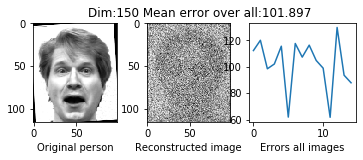

Mean error 101.89710174264711


In [3]:
formatErr = "{:.3f}".format(np.asarray(errors).mean())    
    
grid = plt.GridSpec(2, 9)

plt.subplot(grid[0, 0:3])
plt.title('Dim:'+str(k)+' Mean error over all:'+formatErr,x=2)
plt.imshow(images_test[14], cmap='Greys_r')
plt.xlabel('Original person')

pred = model(data_test[14, :])
pred_np = pred.data.numpy()
pred_np += mean_data
img_reconst = pred_np.reshape((116, 98))
plt.subplot(grid[0, 3:6])
plt.imshow(img_reconst, cmap='Greys_r')
plt.xlabel('Reconstructed image')

plt.subplot(grid[0, 6:])
plt.plot(np.arange(len(images_test)), errors)
plt.xlabel('Errors all images')

plt.savefig("pca_ae_solution.png")
plt.show()

print("Mean error", np.asarray(errors).mean())